# $D_{s1}(2460)^+\to D_s^+\gamma$ production study
## Yields
### MonteCarlo analysis
#### MCReweighting: Multiplicity proxies

Iván Cambón Bouzas

Instituto Galego de Física de Altas Enerxías

Universidade de Santiago de Compostela



In [1]:
import ROOT
from datetime import datetime
import numpy as np
import sys 
import uncertainties as un
import pandas as pd 
from particle import Particle
from hep_ml import reweight
from hep_ml.metrics_utils import ks_2samp_weighted
import matplotlib.pyplot as plt
import os
ROOT.EnableImplicitMT()
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyFit')
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyShort')
import RooPyFit as rpf
import RooPyShort as rsh

print(datetime.now())

ROOT.gROOT.ProcessLine(".L lhcbStyle.C")
ROOT.lhcbStyle()

Welcome to JupyROOT 6.28/04
2024-02-29 10:55:26.040782
-------------------------
Set LHCb Style - May 2021
-------------------------


In [2]:
if not os.path.exists("./Graphs"):
    os.makedirs("./Graphs")
else:
    print("Graphs directory already exists")

if not os.path.exists("./Results"):
    os.makedirs("./Results")
else:
    print("Results directory already exists")

if not os.path.exists("./Tables"):
    os.makedirs("./Tables")
else:
    print("Tables directory already exists")

Graphs directory already exists
Results directory already exists
Tables directory already exists


## RDataFrame definition

In [3]:
data_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/Data/MagDown/2018'

priv = False
Filt = True

if priv:
    MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Private/'
else:
    if Filt:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/TightCut/'
    else:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/DecProdCut/'

data_files = "DsJ_Data_MagD18_1*.root"         # around 10% of the data sample
MC_files   = "Ds1DsGamma*.root"
dtt = "DsGammaTuple"

tdf_data = ROOT.RDataFrame("{0}/DecayTree".format(dtt), "{0}/{1}".format(data_path, data_files))
tdf_data = tdf_data.Define("DsgM", "Dsg_M-Ds_M+1969")

tdf_MC = ROOT.RDataFrame("{0}/DecayTree".format(dtt), "{0}/{1}".format(MC_path, MC_files))
tdf_MC = tdf_MC.Define("DsgM", "Dsg_M-Ds_M+1969")

## MCmatching and selection RDF

In [4]:
TRUEIDs = rsh.TRUEIDs()
TRUEIDs_dtt = TRUEIDs[dtt]
TRUEIDs_Ds1 = TRUEIDs_dtt["Ds1DsGamma"]

off_sel  = "gamma_PT > 1200 && gamma_CL > 0.7 && abs(Ds_M-1969) < 20 && DsgM < 2700"
nPVs_req = "nPVs == 1"

L0_cond    = "(Ds_L0HadronDecision_TOS == 1 | Dsg_L0Global_TIS == 1)"
HLT1_cond  = "(Ds_Hlt1TrackMVADecision_TOS == 1 | Ds_Hlt1TwoTrackMVADecision_TOS == 1)"
HLT2_cond  = "(Ds_Hlt2CharmHadDspToKmKpPipDecision_TOS == 1)"
trig_conds = "{0} && {1} && {2}".format(L0_cond, HLT1_cond, HLT2_cond) 

data_sel = "{0} && {1} && {2}".format(off_sel, nPVs_req, trig_conds)
MC_sel   = "{0} && {1} && {2} && {3}".format(off_sel, nPVs_req, trig_conds, TRUEIDs_Ds1)

tdf_data_sel = tdf_data.Filter(data_sel)
tdf_MC_ID    = tdf_MC.Filter(MC_sel)

In [5]:
columns = ["DsgM", "nVeloTracks", "nTracks", "nLongTracks", "nVeloClusters", "nBackTracks", "nSPDHits"]

df_data_sel = rsh.rdf_to_pdf(tdf_data_sel, columns=columns)
df_MC_ID    = rsh.rdf_to_pdf(tdf_MC_ID, columns=columns)

binnings_data = [int(np.max(df_data_sel[columns[i]]) - np.min(df_data_sel[columns[i]])) for i in range(len(columns))]
binnings_MC   = [int(np.max(df_MC_ID[columns[i]]) - np.min(df_MC_ID[columns[i]])) for i in range(len(columns))]

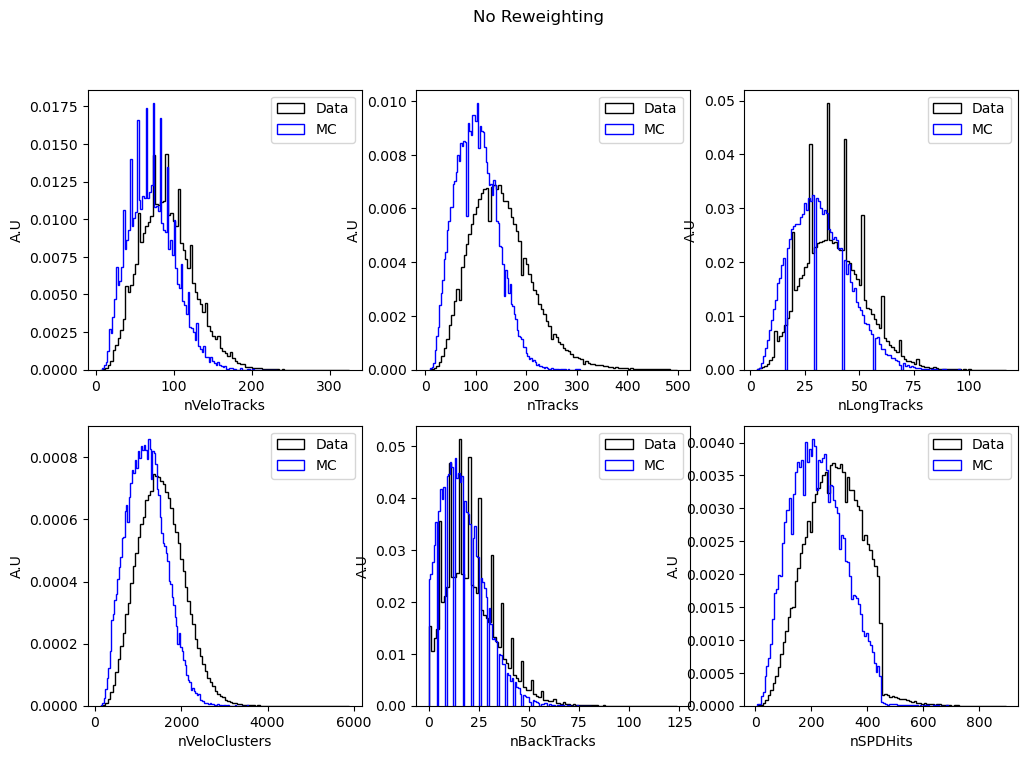

---------------------------------------------------------------------------
Data entries: 264053, MC entries: 34622
---------------------------------------------------------------------------
KS test over original MC distributions
KS over  nVeloTracks  =  0.22058666071685773
KS over  nTracks  =  0.3462111385574576
KS over  nLongTracks  =  0.17700464868938554
KS over  nVeloClusters  =  0.26687083992862554
KS over  nBackTracks  =  0.14040099803447126
KS over  nSPDHits  =  0.236758214225174
---------------------------------------------------------------------------


In [6]:
plt.figure(1, figsize=(12,8))
for i in range(1, len(columns)):
    plt.subplot(2, int(len(columns)/2), i)
    plt.hist(df_data_sel[columns[i]], bins=100, color="black", histtype="step", label="Data", density=True)
    plt.hist(df_MC_ID[columns[i]], bins=100, color="blue", histtype="step", label="MC", density=True)
    plt.xlabel(columns[i])
    plt.ylabel("A.U")
    plt.legend()
plt.suptitle("No Reweighting")
plt.savefig("Graphs/Comp_DsgL_multplicity_proxies_nMCR.pdf", dpi=300, bbox_inches='tight')
plt.show()

print("---------------------------------------------------------------------------")
print("Data entries: {0}, MC entries: {1}".format(len(df_data_sel), len(df_MC_ID)))
print("---------------------------------------------------------------------------")

# KS test
print("KS test over original MC distributions")
for i in range(1, len(columns)):
    print('KS over ', columns[i], ' = ', 
          ks_2samp_weighted(df_MC_ID[columns[i]], df_data_sel[columns[i]],
                            weights1=np.ones(len(df_MC_ID[columns[i]])),
                            weights2=np.ones(len(df_data_sel[columns[i]])),
                            )
          )
print("---------------------------------------------------------------------------")

## Bins-based reweighting

In [7]:
df_MC_ID_new = rsh.bin_based_reweight(tdf_MC_ID, tdf_data_sel, columns, "nVeloTracks")

KS test over MC distributions
---------------------------------------------------------------------------
Before reweighting
KS over  nVeloTracks  =  0.22058666071685773
After reweighting
KS over  nVeloTracks  =  0.003870363797815357
---------------------------------------------------------------------------


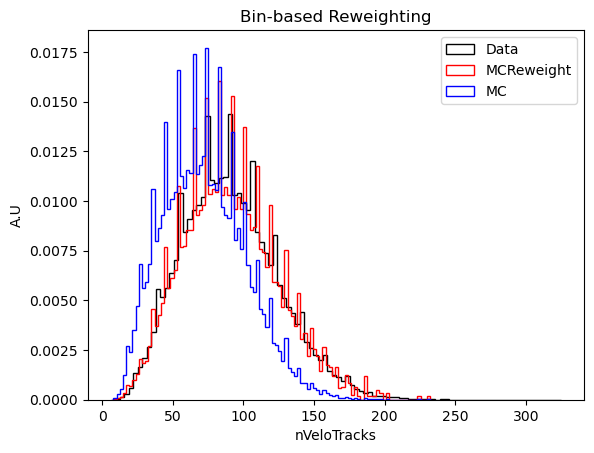

In [8]:
plt.figure(1)
plt.hist(df_data_sel["nVeloTracks"],  bins=100, color='black', histtype="step", label="Data", density=True)
plt.hist(df_MC_ID_new["nVeloTracks"], bins=100, color='red', histtype="step", label="MCReweight", density=True, weights=df_MC_ID_new["nVeloTracks_mult_bbw"])
plt.hist(df_MC_ID_new["nVeloTracks"], bins=100, color='blue', histtype="step", label="MC", density=True)
plt.xlabel("nVeloTracks")
plt.ylabel("A.U")
plt.legend()
plt.title("Bin-based Reweighting")
plt.savefig("Graphs/Comp_DsgL_nVeloTracks_MCR_BBR.pdf", dpi=300, bbox_inches='tight')

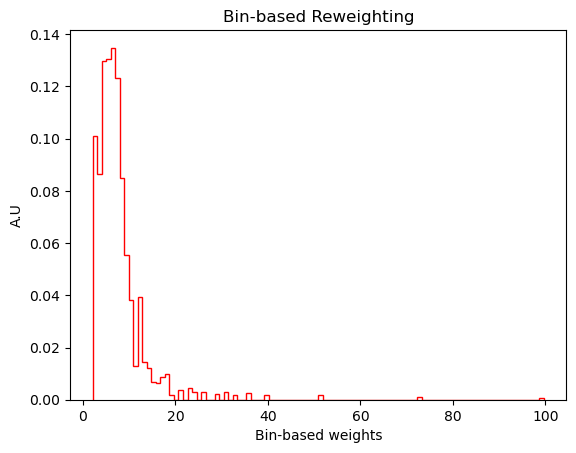

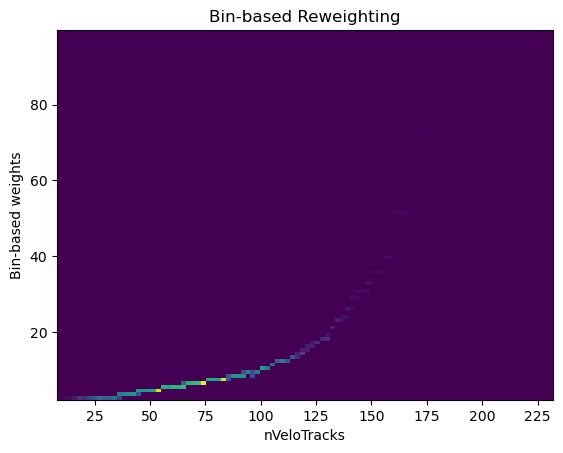

In [9]:
plt.figure(3)
plt.hist(df_MC_ID_new["nVeloTracks_mult_bbw"], bins=100, color="red", histtype="step", density=True)
plt.xlabel("Bin-based weights")
plt.ylabel("A.U")
plt.title("Bin-based Reweighting")
plt.savefig("Graphs/Comp_DsgL_weigths_MCR_BBR.pdf", dpi=300, bbox_inches='tight')

plt.figure(5)
plt.hist2d(df_MC_ID_new["nVeloTracks"], df_MC_ID_new["nVeloTracks_mult_bbw"], bins=100, density=True)
plt.xlabel("nVeloTracks")
plt.ylabel("Bin-based weights")
plt.title("Bin-based Reweighting")
plt.savefig("Graphs/Comp_DsgL_nVeloTracks_weights_MCR_BBR.pdf", dpi=300, bbox_inches='tight')

## Gradient Boost Reweighter

In [10]:
reweighter = reweight.GBReweighter(n_estimators=250, learning_rate=0.1, max_depth=3, min_samples_leaf=1000,
                                   gb_args={'subsample': 0.4})

reweighter.fit(df_MC_ID, df_data_sel)

gb_weights_MC = reweighter.predict_weights(df_MC_ID)

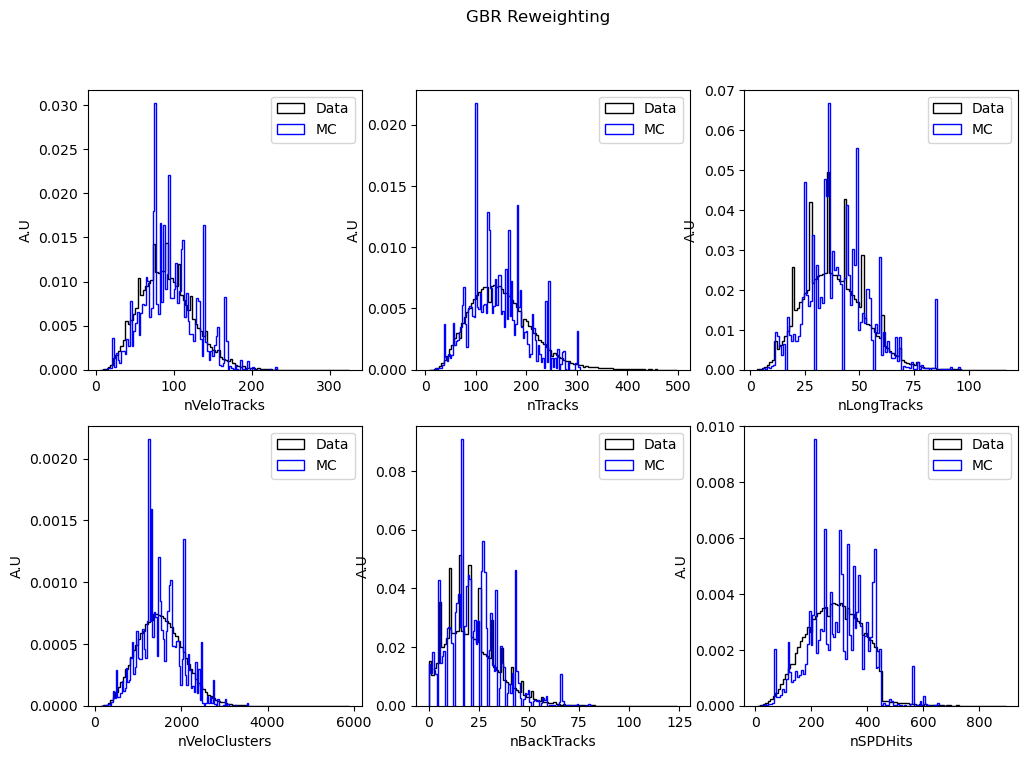

KS test over reweigthed MC distributions
---------------------------------------------------------------------------
KS over  nVeloTracks  =  0.08250972962736469
KS over  nTracks  =  0.05996740711412407
KS over  nLongTracks  =  0.08419949618614408
KS over  nVeloClusters  =  0.05685055515879642
KS over  nBackTracks  =  0.08125212722578101
KS over  nSPDHits  =  0.059963627136364994
---------------------------------------------------------------------------


In [11]:
plt.figure(2, figsize=(12,8))
for i in range(1, len(columns)):
    plt.subplot(2, int(len(columns)/2), i)
    plt.hist(df_data_sel[columns[i]], bins=100, color="black", histtype="step", label="Data", density=True)
    plt.hist(df_MC_ID[columns[i]], bins=100, color="blue", histtype="step", label="MC", density=True, weights=gb_weights_MC)
    plt.xlabel(columns[i])
    plt.ylabel("A.U")
    plt.legend()
plt.suptitle("GBR Reweighting")
plt.savefig("Graphs/Comp_DsgL_multplicity_proxies_MCR_GBR.pdf", dpi=300, bbox_inches='tight')
plt.show()

print("KS test over reweigthed MC distributions")
print("---------------------------------------------------------------------------")
for i in range(1, len(columns)):
    print('KS over ', columns[i], ' = ', 
          ks_2samp_weighted(df_MC_ID[columns[i]], df_data_sel[columns[i]],
                            weights1=gb_weights_MC,
                            weights2=np.ones(len(df_data_sel[columns[i]])),
                            )
          )
print("---------------------------------------------------------------------------")


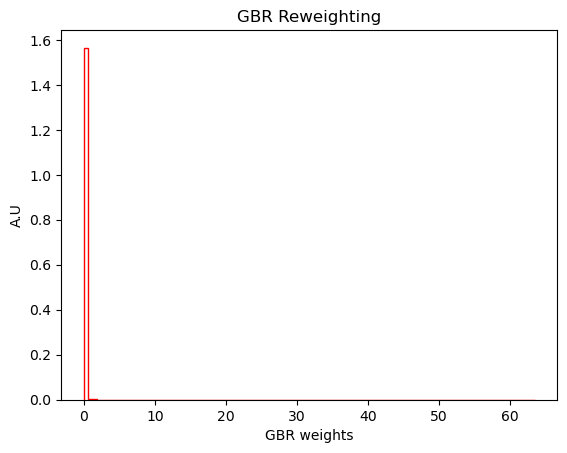

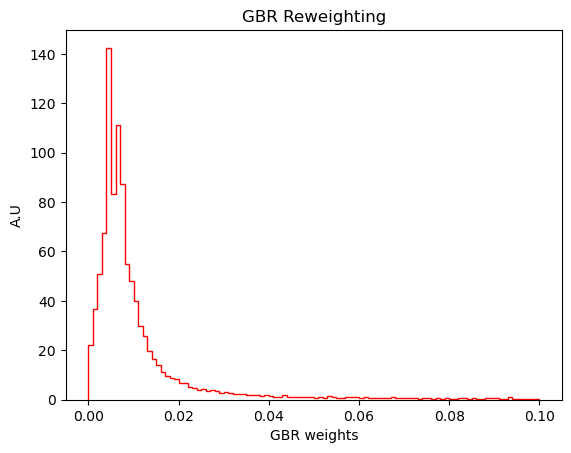

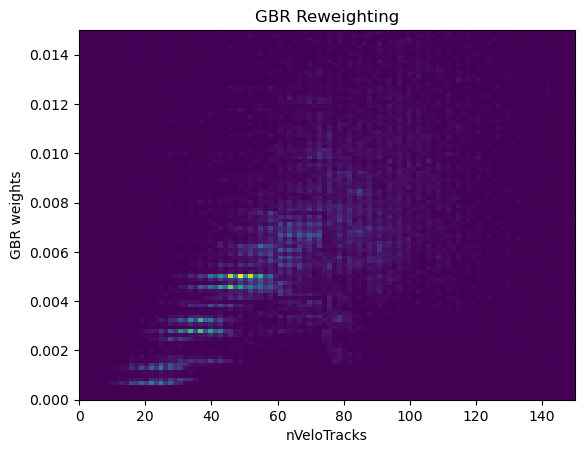

In [12]:
plt.figure(3)
plt.hist(gb_weights_MC, bins=100, color="red", histtype="step", density=True)
plt.xlabel("GBR weights")
plt.ylabel("A.U")
plt.title("GBR Reweighting")
plt.savefig("Graphs/Comp_DsgL_weigths_MCR_GBR.pdf", dpi=300, bbox_inches='tight')

plt.figure(4)
plt.hist(gb_weights_MC, bins=100, range=(0, 0.10), color="red", histtype="step", density=True)
plt.xlabel("GBR weights")
plt.ylabel("A.U")
plt.title("GBR Reweighting")
plt.savefig("Graphs/Comp_DsgL_weigths_MCR_GBR_2.pdf", dpi=300, bbox_inches='tight')

plt.figure(5)
plt.hist2d(df_MC_ID["nVeloTracks"], gb_weights_MC, bins=100, range=[[0, 150], [0, 0.015]], density=True)
plt.xlabel("nVeloTracks")
plt.ylabel("GBR weights")
plt.title("GBR Reweighting")
plt.savefig("Graphs/Comp_DsgL_nVeloTracks_weigths_MCR_GBR.pdf", dpi=300, bbox_inches='tight')